In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score
import scipy.stats

import seaborn as sns
from MutBkgd import MutationBackground

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; 

<IPython.core.display.Javascript object>

In [10]:
prefix = 'HIS.'

s_het = np.load('../data/gene/s_het.npy').item()
prec = np.load('../data/gene/prec.npy').item()
pli = np.load('../data/gene/pli.npy').item()
lofz = np.load('../data/gene/lofz.npy').item()

HS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score < 0.5)
HIS_gene = set(gene for gene, pli_score in pli.iteritems() if pli_score >= 0.5)
prec_5 = set(gene for gene, pli_score in prec.iteritems() if pli_score >0.5)
lofz3 = set(gene for gene, score in lofz.iteritems() if score >= 3)

if prefix == 'HIS.':
    geneset = HIS_gene 
elif prefix == 'HS.':
    geneset = HS_gene
else:
    geneset = geneset

# compare confusion matrix

In [4]:
def plot_multi_confusion_matrix(df, y_true, dataset, save=False,
                                class_names = ['damage_negative', 'damage_positive']):
    '''take a dataframe with predictors and y_true value, output multiple confusion matrix plot
    '''
    
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56)}
    
    y_preds, y_algos = [], []
    for key, (col, threshold) in col_dict.items():
        y_algos.append(key)
        y_preds.append(convert2binary(df, col, threshold))

    infos = []
    for y_pred, y_algo in zip(y_preds, y_algos):
        # Compute confusion matrix
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cnf_matrix = confusion_matrix(y_true, y_pred)
        fdr = 1 - precision_score(y_true, y_pred)
        np.set_printoptions(precision=2)

        title = '../figure/' + dataset + y_algo + '.png'
        # Plot non-normalized confusion matrix
        figure_title = 'Confusion matrix, without normalization\n{}\n{}\n accuracy: {:.2f}\n f1: {:.2f}\n'.format(
            dataset, y_algo, accuracy, f1)
        fig = plt.figure(figsize = (5,5))
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title=figure_title)
        
        if save:
            infos.append([y_algo, accuracy, f1, fdr])
            fig.savefig(title)
            plt.close()
        else:
            plt.show()
    labels = ['Col', 'accuracy', 'f1', 'FDR']            
    df = pd.DataFrame(infos,columns=labels)
    display(df)

def convert2binary(df, col, threshold):
    '''take a dataframe, col to compare, threshold, return the binary vector
        convert to more elegent lambda function way 
        http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    '''
    values = np.array(df[col].values)
    index = values >= threshold
    values[index] = 1
    values[~index] = 0
    return values

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=45)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
class_names = ['damage_negative', 'damage_positive'] # 0 for 'damage_negative', 1 for 'damage_positive'

validation = '../data/output/output_data_mode5.csv'
fname = validation
df = pd.read_csv(fname)
df = df[df.training==0]
y_true = df.pop('target')
dataset = 'validation(20% HGMD,DiscovEHR)'
plot_multi_confusion_matrix(df, y_true, dataset, save=True)

/home/local/ARCS/hq2130/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (58,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Col,accuracy,f1,FDR
0,all_missense,0.501803,0.668267,0.498197
1,PP2-HVAR,0.742640,0.708286,0.178731
2,cnn_0.7,0.930102,0.929409,0.057822
3,eigen_pred10,0.630583,0.442665,0.088930
4,FATHMM,0.782696,0.759156,0.144786
5,cnn_0.05,0.867715,0.882880,0.205648
6,cadd20,0.823353,0.838845,0.226453
7,cnn_0.6,0.933106,0.933743,0.071781
8,cnn_0.5,0.933607,0.935006,0.081118
9,cnn_0.4,0.930903,0.933230,0.094120


In [18]:
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']

for fname in fnames:
    df = pd.read_csv(fname)
    y_true = df.pop('target')
    dataset = fname.split('_')[-1].split('.')[0]
    print dataset
    plot_multi_confusion_matrix(df, y_true, dataset, save=True)


test1


,Col,accuracy,f1,FDR
0,all_missense,0.736264,0.848101,0.263736
1,PP2-HVAR,0.736264,0.800000,0.094340
2,cnn_0.7,0.802198,0.844828,0.000000
3,eigen_pred10,0.439560,0.385542,0.000000
4,FATHMM,0.637363,0.685714,0.052632
5,cnn_0.05,0.901099,0.932331,0.060606
6,cadd20,0.868132,0.914286,0.123288
7,cnn_0.6,0.802198,0.847458,0.019608
8,cnn_0.5,0.846154,0.885246,0.018182
9,cnn_0.4,0.868132,0.903226,0.017544


test2


,Col,accuracy,f1,FDR
0,all_missense,0.398489,0.569885,0.601511
1,PP2-HVAR,0.706509,0.661755,0.388109
2,cnn_0.7,0.895002,0.868892,0.135291
3,eigen_pred10,0.631538,0.252358,0.340862
4,FATHMM,0.843084,0.808057,0.211743
5,cnn_0.05,0.746416,0.754823,0.386045
6,cadd20,0.612360,0.651818,0.492412
7,cnn_0.6,0.887834,0.863797,0.163172
8,cnn_0.5,0.882991,0.861531,0.184816
9,cnn_0.4,0.869430,0.849822,0.215549


addtest1


,Col,accuracy,f1,FDR
0,all_missense,0.716757,0.835013,0.283243
1,PP2-HVAR,0.693188,0.762901,0.144925
2,cnn_0.7,0.927204,0.948355,0.035227
3,eigen_pred10,0.382282,0.268725,0.112998
4,FATHMM,0.883076,0.917126,0.067911
5,cnn_0.05,0.873966,0.918557,0.144467
6,cadd20,0.730130,0.818769,0.210691
7,cnn_0.6,0.933305,0.953333,0.043759
8,cnn_0.5,0.934726,0.954743,0.051031
9,cnn_0.4,0.930965,0.952616,0.062444


addtest2


,Col,accuracy,f1,FDR
0,all_missense,0.635791,0.777350,0.364209
1,PP2-HVAR,0.740488,0.788811,0.182743
2,cnn_0.7,0.910653,0.928564,0.055686
3,eigen_pred10,0.451063,0.280358,0.158058
4,FATHMM,0.844529,0.873788,0.097072
5,cnn_0.05,0.834427,0.883622,0.201234
6,cadd20,0.743243,0.822075,0.265236
7,cnn_0.6,0.912490,0.931173,0.068731
8,cnn_0.5,0.912359,0.931948,0.079678
9,cnn_0.4,0.906849,0.928729,0.095778


train


,Col,accuracy,f1,FDR
0,all_missense,0.664720,0.798597,0.335280
1,PP2-HVAR,0.769853,0.818335,0.139153
2,cnn_0.7,0.924520,0.942426,0.044143
3,eigen_pred10,0.470965,0.365571,0.098938
4,FATHMM,0.857127,0.889641,0.085770
5,cnn_0.05,0.856228,0.901946,0.175028
6,cadd20,0.777828,0.847893,0.221987
7,cnn_0.6,0.929462,0.947022,0.054414
8,cnn_0.5,0.930024,0.948018,0.063623
9,cnn_0.4,0.928451,0.947316,0.072250


# ROC

In [6]:
def plot_roc(df, y_true, label):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    algos = ['cnn_prob', 'MetaSVM_rankscore', 'MetaLR_rankscore', 'M-CAP_rankscore', 
             'DANN_rankscore','CADD_phred', 'Eigen-phred','Polyphen2_HVAR_rankscore', 
             'MutationTaster_converted_rankscore', 'FATHMM_converted_rankscore', 
             'fathmm-MKL_coding_rankscore']
    for algo in algos:
        index = (df[algo]!= -1) & (df[algo]!= 0)
        y_score = df.ix[index][algo].values
        y_true_nomissing = y_true[index]

        fpr[algo], tpr[algo], _ = roc_curve(y_true_nomissing, y_score)
        roc_auc[algo] = auc(fpr[algo], tpr[algo])
    # jump comes from missing value

    plt.figure(figsize = (10,10))
    lw = 2
    for algo in algos:
        plt.plot(fpr[algo], tpr[algo], lw=lw, 
                 label='{} ROC curve (area = {:.2f})'.format(algo, roc_auc[algo]))

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    total = len(y_true)
    pos = sum(y_true)
    neg = total - pos
    
    plt.title('Receiver operating characteristic of {}: {} positive, {} negative'.format(label, pos, neg))
    plt.legend(loc="lower right", fontsize = 'medium')
    plt.show()
    
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters based on distance
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'dist' : pd.Series(abs(tpr-fpr), index=i), 'threshold' : pd.Series(threshold, index=i),
                        'fpr':pd.Series(fpr, index=i), 'tpr':pd.Series(tpr, index=i)})
    roc_t = roc.ix[roc.dist.argsort()]
    return roc_t.tail(3)

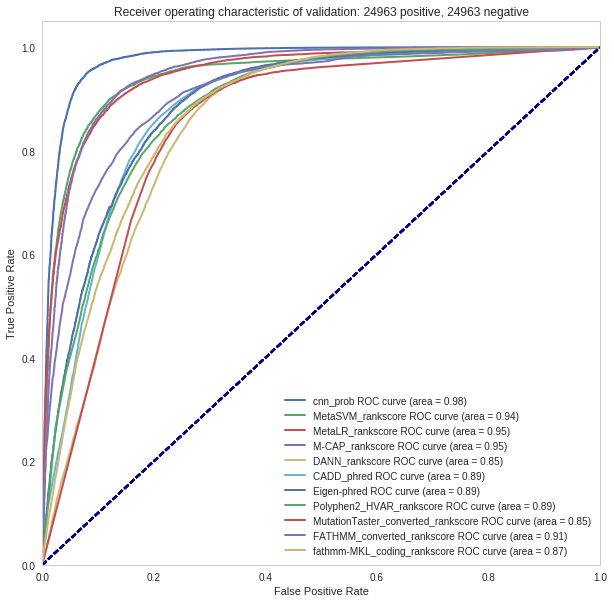

,dist,fpr,threshold,tpr
8328,0.869607,0.081921,0.520358,0.951528
8294,0.869607,0.080239,0.533932,0.949846
8326,0.869687,0.081801,0.521909,0.951488


In [7]:
class_names = ['damage_negative', 'damage_positive']
fname = validation
df = pd.read_csv(fname)
y_true = df.pop('target')
plot_roc(df, y_true, label = 'validation')
Find_Optimal_Cutoff(y_true, df['cnn_prob'])

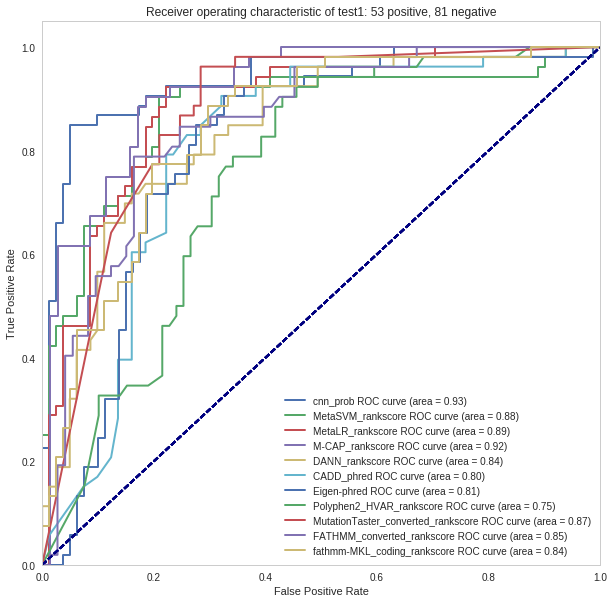

/home/local/ARCS/hq2130/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


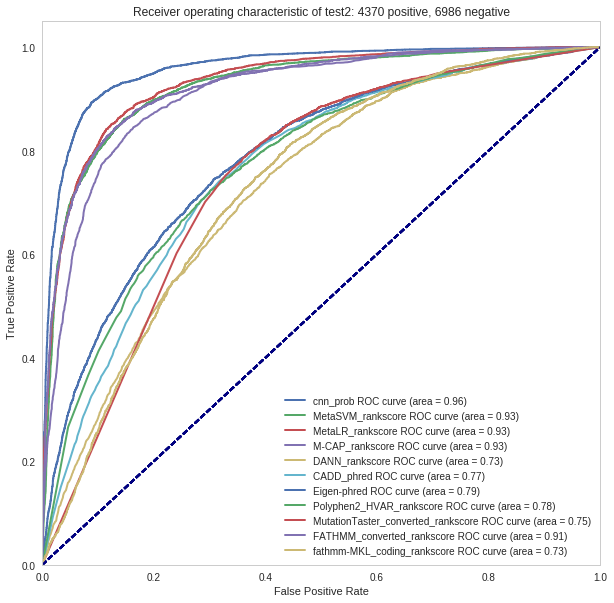

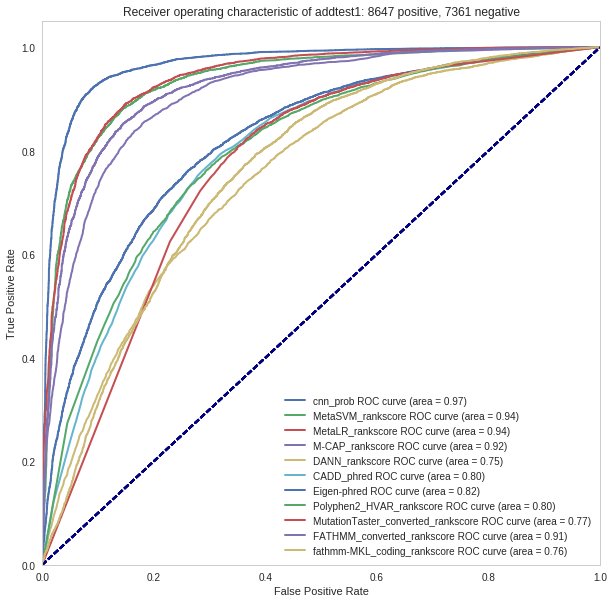

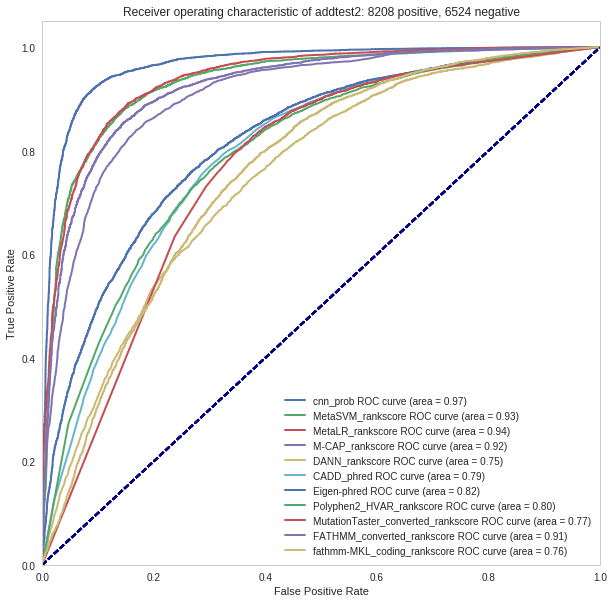

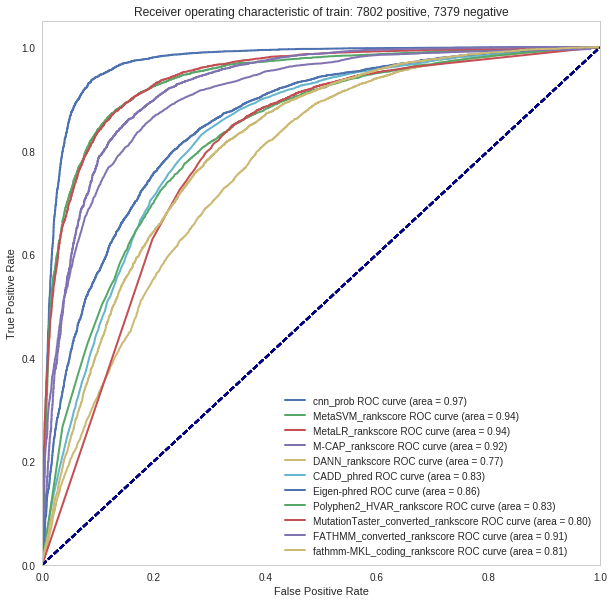

In [8]:
# metaSVM test
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.'+prefix+'reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.'+prefix+'reformat.cnn.csv']
labels = []
for fname in fnames:
    labels.append(fname.split('_')[-1].split('.')[0])
    
for fname, lable in zip(fnames, labels):
    df = pd.read_csv(fname)
    y_true = df.pop('category')
    index = y_true == 'TP'
    y_true[index] = 1
    y_true[~index] = 0
    y_true = y_true.astype(int)
    plot_roc(df, y_true, lable)

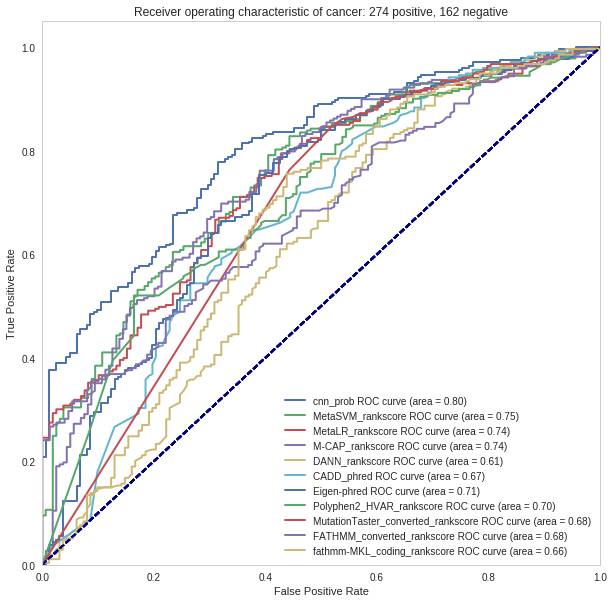

In [18]:
class_names = ['cancer_passengers', 'cancer_hotspot']
fname = '../data/cancer_hotspots/cancer.'+prefix+'reformat.cnn.csv'
df = pd.read_csv(fname)
y_true = df.pop('target')
plot_roc(df, y_true, label = 'cancer')

# cancer hotspot among oncogene / TS genes

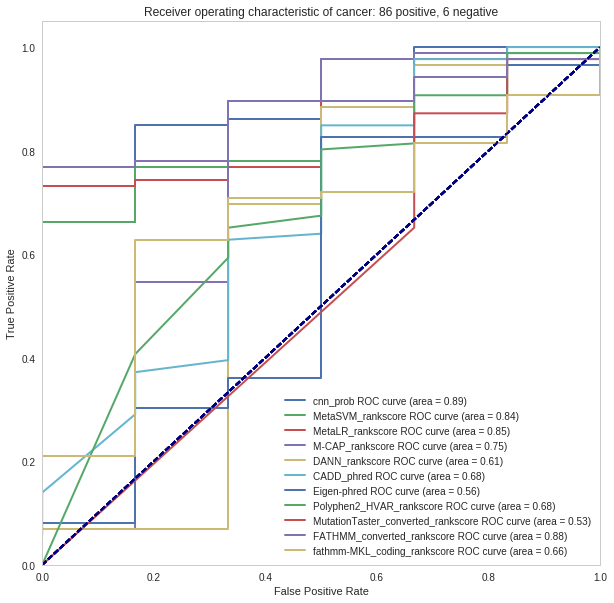

In [23]:
class_names = ['cancer_passengers', 'cancer_hotspot']
fname = '../data/cancer_hotspots/cancer.HIS.reformat.cnn.csv'
cancer_HIS = pd.read_csv(fname)
fname = '../data/cancer_hotspots/cancer.HS.reformat.cnn.csv'
cancer_HS = pd.read_csv(fname)


cancer= pd.concat([cancer_HIS, cancer_HS], ignore_index=True)
with open('../data/gene/oncogenes.txt') as f:
    onco = set(line.strip() for line in f.readlines())

with open('../data/gene/tumor_sup.txt') as f:
    tumor_sup = set(line.strip() for line in f.readlines())
    
geneset = tumor_sup
index =  cancer['genename'].isin(geneset) 
cancer = cancer[index]

y_true = cancer.pop('target')
plot_roc(cancer, y_true, label = 'cancer')

In [16]:
cancer

,Unnamed: 0,MutationAssessor_score_rankscore,VEST3_rankscore,Polyphen2_HDIV_rankscore,Polyphen2_HVAR_rankscore,SIFT_converted_rankscore,PROVEAN_converted_rankscore,MetaSVM_rankscore,MetaLR_rankscore,FATHMM_converted_rankscore,...,hg19_chr,hg19_pos(1-based),ref,alt,category,source,INFO,disease,genename,cnn_prob
0,0,0.89545,0.84226,0.71542,0.66345,0.78421,0.58039,0.45223,0.47762,0.29862,...,1,11169375,A,C,cancerHotspot,cbioportal,NaN,NaN,MTOR,0.296545
1,1,0.85078,0.76964,0.71542,0.69679,0.61383,0.76057,0.86990,0.87447,0.80828,...,1,11172950,G,T,cancerHotspot,cbioportal,NaN,NaN,MTOR,0.460268
2,2,0.83550,0.92394,0.58818,0.60381,0.78421,0.68368,0.89463,0.88009,0.78208,...,1,11184573,G,T,cancerHotspot,cbioportal,NaN,NaN,MTOR,0.870902
3,3,0.92131,0.94024,0.59204,0.52460,0.91219,0.98499,0.85952,0.80881,0.69667,...,1,11217230,C,A,cancerHotspot,cbioportal,NaN,NaN,MTOR,0.656574
4,4,0.75606,0.93672,0.32590,0.60844,0.27624,0.74863,0.83372,0.85445,-1.00000,...,1,53692748,A,G,cancerHotspot,cbioportal,NaN,NaN,MAGOH,0.189644
5,5,0.39491,0.29252,0.18876,0.23873,0.49561,0.35968,0.51562,0.44572,-1.00000,...,1,54871665,T,C,cancerHotspot,cbioportal,NaN,NaN,SSBP3,0.009061
6,6,0.90345,0.90583,0.28393,0.39429,0.45705,0.66737,0.87434,0.85528,0.83507,...,1,115256529,T,C,cancerHotspot,cbioportal,NaN,NaN,NRAS,0.977797
7,7,0.90021,0.99469,0.33834,0.42157,0.45705,0.85661,0.80509,0.78362,0.72793,...,1,115258744,C,T,cancerHotspot,cbioportal,NaN,NaN,NRAS,0.839389
8,8,0.87909,0.94735,0.32340,0.42664,0.55478,0.84711,0.85237,0.84234,0.78436,...,1,115258747,C,T,cancerHotspot,cbioportal,NaN,NaN,NRAS,0.844466
9,9,0.94055,0.93672,0.89865,0.85043,0.78421,0.95146,0.91927,0.86835,0.69167,...,1,209879200,G,A,cancerHotspot,cbioportal,NaN,NaN,HSD11B1,0.557229


# enrichment

In [14]:
fname = '../data/gene/mis_rate_hongjian_onegene_0526.txt'
mutation_bkgrd = MutationBackground(fname)

def display_enrichment(case_info, control_info, case_disease, geneset, sort_key='Col'):
    
    print case_disease
    df_case, case_disease, disease_size = case_info 
    df_control, control_disease, disease_size = control_info 
    case_size = 0.0
    for disease in case_disease:
        if disease in disease_size:
            case_size += disease_size[disease]
    control_size = 0.0
    for disease in control_disease:
        control_size += disease_size[disease]
    print 'case size:{} control size:{}'.format(case_size, control_size)
    
    # add PDmis columns
    df_case['PDmis'] = np.where((df_case['CADD_phred'] >= 15) & (df_case['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    df_control['PDmis'] = np.where((df_control['CADD_phred'] >= 15) & (df_control['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHMM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56)}

    
    infos = [] 
    for col_name, (col, threshold) in col_dict.items():
        case_count = np.sum(convert2binary(df_case, col, threshold))
        control_count = np.sum(convert2binary(df_control, col, threshold))
        total_counts = case_count + control_count
        control_count = max(control_count, 1)
        enrich = float(case_count) / case_size / (float(control_count) / control_size)
        pvalue = scipy.stats.binom_test(case_count, total_counts,
                                            case_size / (case_size + control_size))
        risk_gene = case_count * (enrich - 1) / enrich
        enrich = max(enrich, 1)
        tpr = (enrich - 1) / enrich
        
        exp = mutation_bkgrd.expectation(geneset, col_name) * case_size
        if exp == 0: # use control instead
            exp = case_count - risk_gene
            
        exp_enr = case_count / exp
        exp_risk_gene = case_count * (exp_enr - 1) / exp_enr
        exp_tpr = (exp_enr - 1) / exp_enr
        
        
        infos.append([col_name, case_count, control_count, 
                      enrich, pvalue, risk_gene, tpr,
                      exp, exp_enr, exp_risk_gene, exp_tpr])
        
    
    labels = ['Col', 'Case', 'Control', 'enrich', 'pvalue', '# risk gene', 'true positive rate',
              'exp', 'exp_enr', 'exp_risk_gene', 'exp_tpr']            
    df = pd.DataFrame(infos,columns=labels)
    df = df.sort_values(by=sort_key, ascending=True)
    display(df)
    plot_rate_vs_riskvariants(df, title=','.join(case_disease))
    return df

def plot_rate_vs_riskvariants(df, title):
    x = list(df['true positive rate'])
    y = list(df['# risk gene'])
    
#     x = list(df['exp_tpr'])
#     y = list(df['exp_risk_gene'])
    methods = list(df['Col'])
    fig, ax = plt.subplots(figsize = (15,10))
    ax.scatter(x, y, s=100)
    for i, txt in enumerate(methods):
        if 'cnn' in txt:
            color = 'red'
        elif 'all_missense' in txt:
            color = 'blue'
        else:
            color = 'black'
        ax.annotate(txt, (x[i],y[i]), fontsize=15, color=color)
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel('true positive rate', fontsize=15)
    ax.set_ylabel('# risk gene', fontsize=15)
    
    case_variants, control_variants = df.ix[df['Col']=='all_missense'][['Case', 'Control']].values[0]
    
    ax.set_title('{}: {} variants in cases, {} variants in controls'.format(title, 
                                            case_variants, control_variants), fontsize=15)  

['ASD']
case size:3953.0 control size:1911.0
do not have rate for cnn_0.7, use control instead
do not have rate for cnn_0.05, use control instead
do not have rate for cnn_0.6, use control instead
do not have rate for cnn_0.5, use control instead
do not have rate for cnn_0.4, use control instead
do not have rate for cnn_0.1, use control instead
do not have rate for cnn_0.3, use control instead
do not have rate for cnn_0.2, use control instead
do not have rate for cnn_best_0.56, use control instead
do not have rate for cnn_0.8, use control instead


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,224.0,60.0,1.804806,2.656845e-05,99.886970,0.445924,185.950776,1.204620,38.049224,0.169863
21,M_CAP>0.025,651.0,232.0,1.356522,4.881681e-05,171.096285,0.262821,591.362463,1.100848,59.637537,0.091609
17,M_CAP>0.05,451.0,159.0,1.371239,5.383392e-04,122.100471,0.270733,429.707226,1.049552,21.292774,0.047212
20,MetaLR>0,286.0,89.0,1.553495,2.136897e-04,101.899006,0.356290,214.860974,1.331093,71.139026,0.248738
18,MetaSVM>0,284.0,86.0,1.596444,9.809073e-05,106.104657,0.373608,206.933053,1.372425,77.066947,0.271362
1,PP2-HVAR,495.0,166.0,1.441554,3.210395e-05,151.620617,0.306304,392.844281,1.260041,102.155719,0.206375
0,all_missense,1187.0,425.0,1.350192,6.579291e-08,307.866039,0.259365,967.661467,1.226669,219.338533,0.184784
19,cadd15,1027.0,360.0,1.379119,8.128087e-08,282.321821,0.274900,795.260780,1.291400,231.739220,0.225647
6,cadd20,934.0,327.0,1.380807,3.119312e-07,257.583987,0.275786,708.871427,1.317587,225.128573,0.241037
11,cadd25,627.0,194.0,1.562427,2.111608e-08,225.701204,0.359970,415.734602,1.508174,211.265398,0.336946


['DDD_new']
case size:4293.0 control size:1911.0
do not have rate for cnn_0.7, use control instead
do not have rate for cnn_0.05, use control instead
do not have rate for cnn_0.6, use control instead
do not have rate for cnn_0.5, use control instead
do not have rate for cnn_0.4, use control instead
do not have rate for cnn_0.1, use control instead
do not have rate for cnn_0.3, use control instead
do not have rate for cnn_0.2, use control instead
do not have rate for cnn_best_0.56, use control instead
do not have rate for cnn_0.8, use control instead


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,507.0,60.0,3.761461,2.800239e-30,372.211931,0.734146,201.944519,2.510591,305.055481,0.601687
21,M_CAP>0.025,1236.0,232.0,2.371539,8.008920e-40,714.819466,0.578333,642.225918,1.924556,593.774082,0.480400
17,M_CAP>0.05,1003.0,159.0,2.808042,5.292128e-42,645.811617,0.643880,466.666614,2.149286,536.333386,0.534729
20,MetaLR>0,650.0,89.0,3.251046,4.825161e-33,450.064364,0.692407,233.341301,2.785619,416.658699,0.641013
18,MetaSVM>0,664.0,86.0,3.436920,7.119860e-36,470.803768,0.709042,224.731494,2.954637,439.268506,0.661549
1,PP2-HVAR,1013.0,166.0,2.716446,1.365846e-40,640.086342,0.631872,426.633063,2.374406,586.366937,0.578842
0,all_missense,2037.0,425.0,2.133545,4.882309e-53,1082.251177,0.531297,1050.890635,1.938356,986.109365,0.484099
19,cadd15,1819.0,360.0,2.249210,1.048995e-52,1010.271586,0.555399,863.661657,2.106149,955.338343,0.525200
6,cadd20,1725.0,327.0,2.348233,5.370875e-54,990.405024,0.574148,769.841901,2.240720,955.158099,0.553715
11,cadd25,1295.0,194.0,2.971446,7.056049e-58,859.185243,0.663464,451.492194,2.868267,843.507806,0.651357


['CHD_yale']
case size:2645.0 control size:1911.0
do not have rate for cnn_0.7, use control instead
do not have rate for cnn_0.05, use control instead
do not have rate for cnn_0.6, use control instead
do not have rate for cnn_0.5, use control instead
do not have rate for cnn_0.4, use control instead
do not have rate for cnn_0.1, use control instead
do not have rate for cnn_0.3, use control instead
do not have rate for cnn_0.2, use control instead
do not have rate for cnn_best_0.56, use control instead
do not have rate for cnn_0.8, use control instead


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,170.0,60.0,2.047070,6.356714e-07,86.954474,0.511497,124.421908,1.366319,45.578092,0.268106
21,M_CAP>0.025,464.0,232.0,1.444991,3.831976e-06,142.890633,0.307954,395.687760,1.172642,68.312240,0.147225
17,M_CAP>0.05,341.0,159.0,1.549502,3.538684e-06,120.929356,0.354632,287.522290,1.185995,53.477710,0.156826
20,MetaLR>0,215.0,89.0,1.745354,6.820734e-06,91.815803,0.427050,143.766070,1.495485,71.233930,0.331321
18,MetaSVM>0,212.0,86.0,1.781035,3.212638e-06,92.968080,0.438529,138.461403,1.531113,73.538597,0.346880
1,PP2-HVAR,324.0,166.0,1.410171,2.909787e-04,94.240712,0.290866,262.856849,1.232610,61.143151,0.188713
0,all_missense,817.0,425.0,1.388891,2.704994e-08,228.760858,0.280001,647.473964,1.261827,169.526036,0.207498
19,cadd15,695.0,360.0,1.394817,2.124644e-07,196.726845,0.283060,532.118584,1.306100,162.881416,0.234362
6,cadd20,633.0,327.0,1.398592,6.337497e-07,180.401884,0.284995,474.314425,1.334558,158.685575,0.250688
11,cadd25,384.0,194.0,1.430094,4.182663e-05,115.486133,0.300745,278.173039,1.380436,105.826961,0.275591


['SSC_yale']
case size:1789.0 control size:1911.0
do not have rate for cnn_0.7, use control instead
do not have rate for cnn_0.05, use control instead
do not have rate for cnn_0.6, use control instead
do not have rate for cnn_0.5, use control instead
do not have rate for cnn_0.4, use control instead
do not have rate for cnn_0.1, use control instead
do not have rate for cnn_0.3, use control instead
do not have rate for cnn_0.2, use control instead
do not have rate for cnn_best_0.56, use control instead
do not have rate for cnn_0.8, use control instead


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate,exp,exp_enr,exp_risk_gene,exp_tpr
4,FATHMM,68.0,60.0,1.210620,0.289628,11.830455,0.173977,84.155310,0.808030,-16.155310,-0.237578
21,M_CAP>0.025,252.0,232.0,1.160280,0.111341,34.811094,0.138139,267.631532,0.941593,-15.631532,-0.062030
17,M_CAP>0.05,180.0,159.0,1.209277,0.082197,31.150706,0.173059,194.471598,0.925585,-14.471598,-0.080398
20,MetaLR>0,88.0,89.0,1.056192,0.763660,4.681842,0.053203,97.239130,0.904985,-9.239130,-0.104990
18,MetaSVM>0,86.0,86.0,1.068195,0.703057,5.490319,0.063841,93.651210,0.918301,-7.651210,-0.088968
1,PP2-HVAR,175.0,166.0,1.126109,0.278881,19.597593,0.111986,177.788621,0.984315,-2.788621,-0.015935
0,all_missense,454.0,425.0,1.141083,0.054342,56.132391,0.123640,437.932296,1.036690,16.067704,0.035391
19,cadd15,378.0,360.0,1.121604,0.121943,40.982732,0.108420,359.909318,1.050265,18.090682,0.047859
6,cadd20,339.0,327.0,1.107394,0.200713,32.875981,0.096979,320.812290,1.056693,18.187710,0.053651
11,cadd25,205.0,194.0,1.128762,0.229658,23.385139,0.114074,188.148040,1.089568,16.851960,0.082205


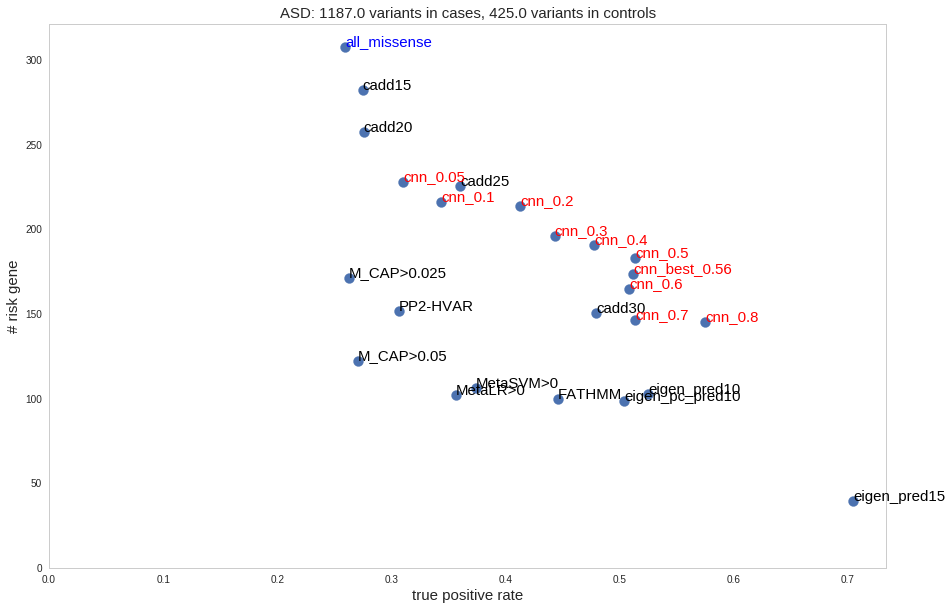

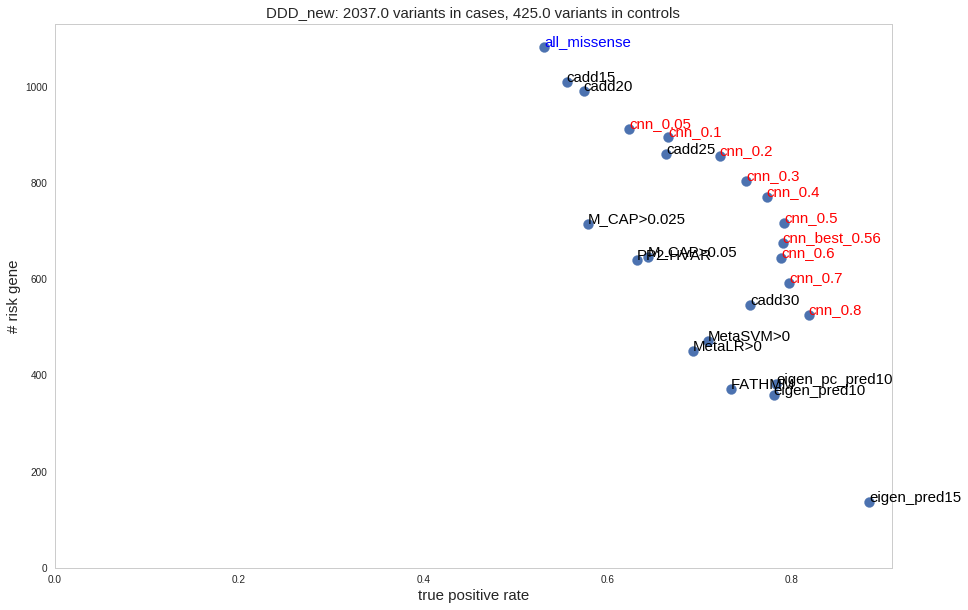

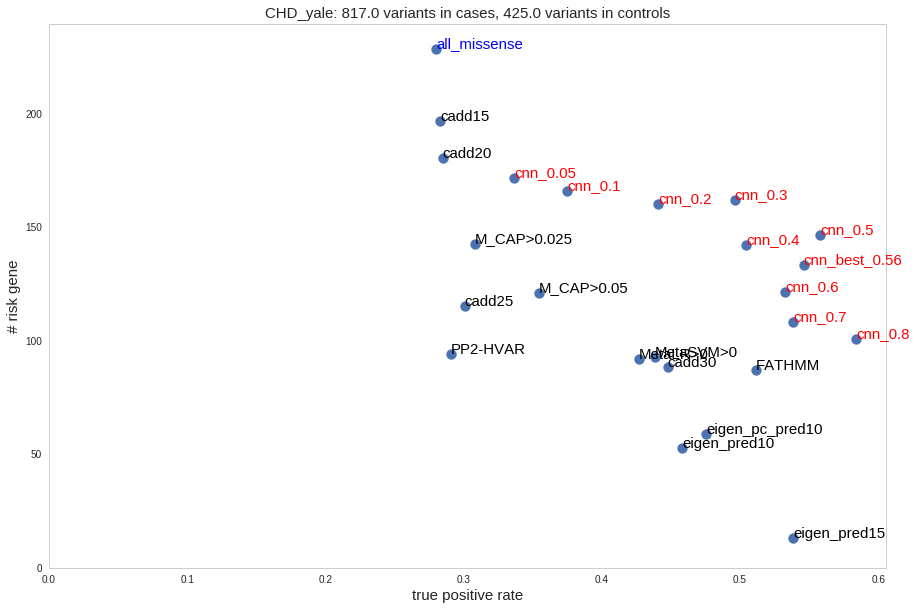

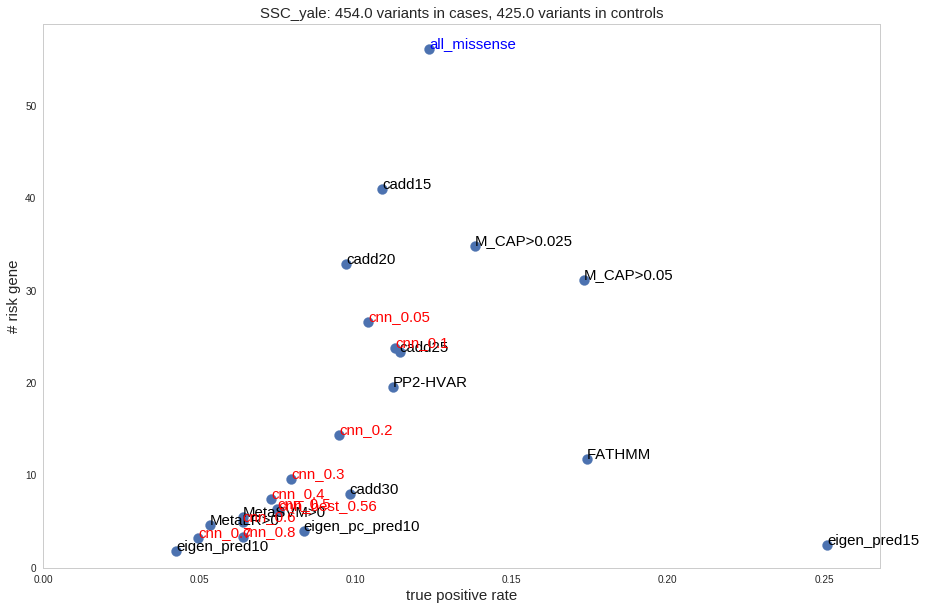

In [15]:


disease_size = {'CHD':2779, 'CDH':307,'CDH_MGH':80,
                'ASD':3953, 'EE':264, 'ID':192,
                'DDD_new':4293, 'DDD':1133, 'SSC':1911,
                'CHD_yale':2645, 'SSC_yale':1789 } 




fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
control_disease = ['SSC_yale']

fname = '../data/case_control/control_1911.anno.rare.'+prefix+'reformat.cnn.csv'
control_disease = ['SSC']

df_control = pd.read_csv(fname)
index = df_control['disease'].isin(control_disease) & df_control['genename'].isin(geneset) 
#index = index & (df_control['prec'] >=0.8)

df_control = df_control[index]
control_info = (df_control, control_disease, disease_size)



# data is a little more than ANNOVAR annotatoin, do a comparison later
case_diseases = [['CHD'], ['CDH'], ['ASD'],['EE'], ['ID'], ['DDD'], 
                 ['CHD', 'CDH', 'ASD','EE', 'ID', 'DDD']]

case_diseases = [['ASD']]

for case_disease in case_diseases:

    fname = '../data/case_control/case.anno.rare.'+prefix+'reformat.cnn.csv'
    df_case = pd.read_csv(fname)
    index = df_case['disease'].isin(case_disease) & df_case['genename'].isin(geneset) 
    
    df_case = df_case[index]
    case_info = (df_case, case_disease, disease_size)
    df = display_enrichment(case_info, control_info, case_disease, geneset)

fname = '../data/case_control/DDD_new_0.2.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['DDD_new']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)

    
fname = '../data/case_control/chd_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['CHD_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)


fname = '../data/case_control/ssc_yale.anno.rare.'+prefix+'reformat.cnn.csv'
case_disease = ['SSC_yale']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)
df = display_enrichment(case_info, control_info, case_disease, geneset)

In [14]:
mutation_bkgrd.rate['GATA4']

{'FATHMM': 2.28996826263e-05,
 'M_CAP>0.025': 2.25417824544e-05,
 'M_CAP>0.05': 2.23268122485e-05,
 'MetaLR>0': 2.16112274644e-05,
 'MetaSVM>0': 2.10965714918e-05,
 'PP2-HVAR': 8.64364379661e-06,
 'all_missense': 2.29145989512e-05,
 'cadd15': 1.75530007436e-05,
 'cadd20': 1.56586872113e-05,
 'cadd25': 8.70931136226e-06,
 'cadd30': 4.09290586572e-06,
 'eigen_pc_pred10': 2.43839090138e-06,
 'eigen_pred10': 2.5614655022e-06,
 'eigen_pred15': 8.72234785152e-07}